# PROJETO FINAL
INTRODUÇÂO AO PROCESSAMENTO DE IMAGENS


Prof. Bruno Luiggi Macchiavello Espinoza


- Lucas Corrêa Boaventura - 211038262

- Gustavo - 

# Bibliotecas

In [298]:
import numpy as np
from PIL import Image
from IPython.display import display
import cv2
import matplotlib.pyplot as plt

In [299]:
img = Image.open("tatiana.png")
print(img.mode)
gray_img = cv2.cvtColor(np.array(img), cv2.COLOR_RGBA2GRAY)

RGBA


## Thresholding

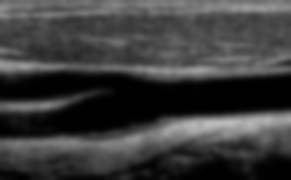

In [300]:
img_low_filter = cv2.GaussianBlur(gray_img, (15, 15), 0)
Image.fromarray(img_low_filter)

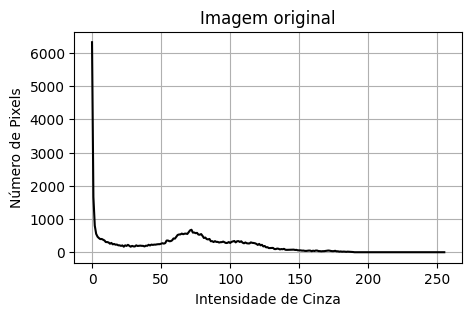

In [301]:
histograma = cv2.calcHist([img_low_filter], [0], None, [256], [0, 256])
plt.figure(figsize=(5, 3))
plt.plot(histograma, color='black')
plt.title('Imagem original')
plt.xlabel('Intensidade de Cinza')
plt.ylabel('Número de Pixels')
plt.grid()
plt.show()

(180, 291)


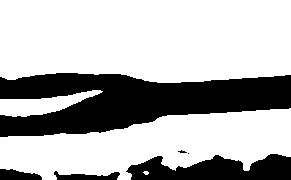

In [302]:
limiar = 25
_, img_bin = cv2.threshold(img_low_filter, limiar, 255, cv2.THRESH_BINARY)
print(img_bin.shape)
Image.fromarray(img_bin)

achei inutil


In [303]:
# def elem_stru(shape) : return np.ones(shape, np.uint8)

# img_open = cv2.morphologyEx(img_bin, cv2.MORPH_OPEN, elem_stru(3))
# display(Image.fromarray(img_open))
# img_open_closed = cv2.morphologyEx(img_open, cv2.MORPH_CLOSE, elem_stru(5))
# Image.fromarray(img_open_closed)

[246, 9, 127]


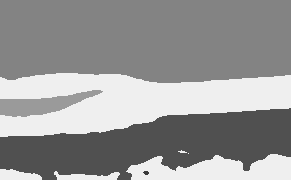

In [304]:
num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(img_bin, connectivity=8)

conection = np.zeros((img_bin.shape[0], img_bin.shape[1]), dtype=np.uint8)
random_color = np.random.randint(0, 255)
colors = [random_color, 255-random_color, 127 ]
print(colors)
for i in range(num_labels):
    conection[labels == i] = np.random.randint(0, 255)
Image.fromarray(conection)

In [306]:
# def use_kmeans(image, clusters, iter=36, precision=4):
#     img = np.float32(np.array(image).reshape((-1, 1)))
#     print(img.shape)
#     criterios = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, iter, precision)

#     _, labels, centers = cv2.kmeans(img, clusters, None, criterios, 10, cv2.KMEANS_RANDOM_CENTERS)
#     centers = np.uint8(centers)

#     display(Image.fromarray(centers[labels.flatten()].reshape(np.array(image).shape)))
#     return labels, centers

# labels, centers=use_kmeans(img_bin, 20)

# output_image = np.zeros_like(img_bin).reshape((-1, 1))
# output_image[labels.flatten()==np.argmin(centers)] = 255

# img_seg = output_image.reshape(np.array(img_bin).shape)

# # print(img_seg)
# display(Image.fromarray(img_seg))


# Image.fromarray(centers[labels.flatten()].reshape(np.array(img_bin).shape))